In [1]:
"""Sandbox module."""
import matplotlib.pyplot as plt
import numpy as np
from fda_funcs import (
    compute_moments,
    compute_principal_components,
    compute_fpc_scores,
    mode_of_variation
)
from misc import (
    cdf_from_density,
    density_from_qd,
    l2_norm,
    norm_pdf,
    quantile_from_cdf,
    riemann_sum_arrays,
    trunc_norm_pdf,
)
from scipy.stats import norm, truncnorm

%matplotlib inline

$\int_0^1 f(t)dt$  wird dann durch die Riemann Summe $1/m \sum_{j=1}^m f(s_j)$ ersetzt ($s_j$  - Gridpunkte, $m$ -  Anzahl der Gridpunkte).

# Functional Data Analysis

Ideas for simulation
- Uni- vs. Multivariate case
- Simulate different normal distributions
- Vary parameters of (generalized) Beta distribution, so principal components can be interpreted as varying parameters

$X(t) = \sum_{k=1}^n η_k φ_k(t)$


## Transformation Method Paper (Petersen & Müller 2016)

In [2]:
# 1. Generate synthetic functional data
n = 200
gridnum = 1000
truncation_point = 5

# Define appropriate grids, both multi- and univariate
grid_densities = np.linspace(
    start=-np.ones(n) * truncation_point,
    stop=np.ones(n) * truncation_point,
    num=gridnum,
)
grid_quantiles = np.linspace(
    start=np.ones(n) * 0.01,
    stop=np.ones(n) * 0.99,
    num=gridnum,
)
grid_densities_univ = np.linspace(
    start=-truncation_point,
    stop=truncation_point,
    num=gridnum,
)
grid_quantiles_univ = np.linspace(start=0.01, stop=0.99, num=gridnum)

# Draw different sigmas
log_sigmas = np.random.default_rng(seed=28071995).uniform(-1.5, 1.5, n)
mus = np.zeros(n)
sigmas = np.exp(log_sigmas)

In [3]:
# Calculate discretized distributions, with different methods, to compare performance

# Calculate densities
a, b = (-truncation_point - mus) / sigmas, (truncation_point - mus) / sigmas
densities_discretized = norm_pdf(grid_densities, mus, sigmas).transpose()
densities_discretized2 = truncnorm.pdf(
    x=grid_densities,
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
densities_discretized3 = trunc_norm_pdf(
    grid_densities,
    mus,
    sigmas,
    -truncation_point,
    truncation_point,
).transpose()

# Calculate distribution functions
cdfs_discretized = cdf_from_density(
    grid_densities_univ,
    densities_discretized,
    axis=1,
)
cdfs_discretized2 = cdf_from_density(
    grid_densities_univ,
    densities_discretized2,
    axis=1,
)
cdfs_discretized3 = cdf_from_density(
    grid_densities_univ,
    densities_discretized3,
    axis=1,
)

# Calculate quantiles
quantiles_discretized = norm.ppf(grid_quantiles, mus, sigmas).transpose()
quantiles_discretized2 = truncnorm.ppf(
    q=grid_quantiles_univ[:, np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantiles_discretized3 = quantile_from_cdf(
    grid_densities.transpose(),
    cdfs_discretized,
    grid_quantiles_univ,
)

# Calculate quantile densities
quantile_densities_discretized = np.reciprocal(
    norm_pdf(quantiles_discretized.transpose(), mus, sigmas),
).transpose()
quantile_densities_discretized2 = np.reciprocal(
    truncnorm.pdf(quantiles_discretized2.transpose(), a=a, b=b, loc=mus, scale=sigmas),
).transpose()
quantile_densities_discretized3 = np.reciprocal(
    trunc_norm_pdf(
        quantiles_discretized3.transpose(),
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    ),
).transpose()

c:\Coding\thesis_frechet_fda\src\frechet_fda\misc.py:137: UserWarning: Not all provided densities integrate to 1!
 Max case of deviation is: 0.2469529824270995 
 Performing normalization...
  warnings.warn(


In [4]:
### Check whether my function differs from scipy func on first generated density sample
eps = 1e-2
(
    (abs(densities_discretized[0] - densities_discretized2[0]) > eps).sum(),
    (abs(cdfs_discretized[0] - cdfs_discretized2[0]) > eps).sum(),
    (abs(quantiles_discretized[0] - quantiles_discretized2[0]) > eps).sum(),
    (
        abs(quantile_densities_discretized[0] - quantile_densities_discretized2[0])
        > eps
    ).sum(),
    (abs(densities_discretized2[0] - densities_discretized3[0]) > eps).sum(),
    (abs(cdfs_discretized2[0] - cdfs_discretized3[0]) > eps).sum(),
    (abs(quantiles_discretized2[0] - quantiles_discretized3[0]) > eps).sum(),
    (
        abs(quantile_densities_discretized2[0] - quantile_densities_discretized3[0])
        > eps
    ).sum(),
)

(0, 0, 0, 0, 0, 0, 0, 296)

### Check how fast the different implementations are.

1. My normal distribution functions
2. Scipy's Truncated normals
3. My truncated normals

(For quantiles always used scipy's implementation of ppf.)

In [5]:
%%timeit
densities_discretized = norm_pdf(grid_densities, mus, sigmas).transpose()
quantiles_discretized = norm.ppf(grid_quantiles, mus, sigmas).transpose()
quantile_densities_discretized = np.reciprocal(
    norm_pdf(quantiles_discretized.transpose(), mus, sigmas),
).transpose()

37.2 ms ± 7.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit
densities_discretized2 = truncnorm.pdf(
    x=grid_densities,
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantiles_discretized2 = truncnorm.ppf(
    q=grid_quantiles,
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantile_densities_discretized2 = np.reciprocal(
    truncnorm.pdf(quantiles_discretized2.transpose(), a=a, b=b, loc=mus, scale=sigmas),
).transpose()

172 ms ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
densities_discretized3 = trunc_norm_pdf(grid_densities, mus, sigmas, a, b).transpose()
quantiles_discretized3 = quantile_from_cdf(
    grid_densities.transpose(),
    cdfs_discretized,
    grid_quantiles_univ,
)
quantile_densities_discretized3 = np.reciprocal(
    trunc_norm_pdf(
        quantiles_discretized3.transpose(),
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    ),
).transpose()

38.8 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 3rd approach faster than scipys
Less accurate with quantiles though. Gets better with higher grid size, but wont do more
than 1000 for computational cost

### Use implementation 3, faster than scipy but still correct

In [8]:
densities_discretized = densities_discretized3
cdfs_discretized = cdfs_discretized3
quantiles_discretized = quantiles_discretized3
quantile_densities_discretized = quantile_densities_discretized3

## Compare my discretized cdf to analytical cdf from scipy, to see whether S shape is there

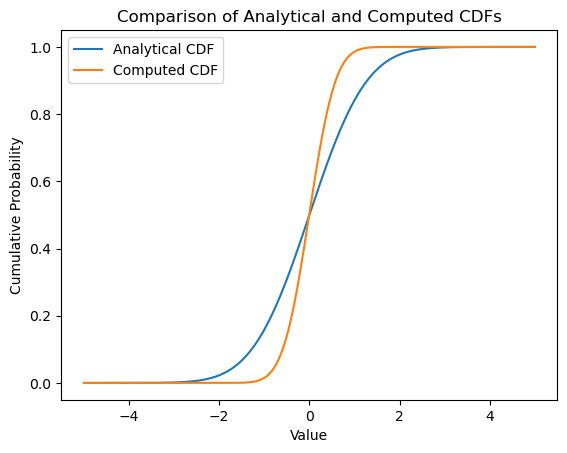

In [9]:
# Analytical CDF for standard normal distribution
analytical_cdf = norm.cdf(grid_densities_univ)

# Plot
plt.plot(grid_densities_univ, analytical_cdf, label="Analytical CDF")
plt.plot(
    grid_densities_univ,
    cdfs_discretized3[0],
    label="Computed CDF",
)  # Adjust index as needed
plt.legend()
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Analytical and Computed CDFs")
plt.show()

## Perform FPCA

In [10]:
# Compute moments to work with in FPCA
mean_function, centered_densities, cov_matrix = compute_moments(densities_discretized)

In [11]:
# Compute the eigenfunctions (principal components) of the covariance matrix
eigenvalues, eigenfunctions = compute_principal_components(cov_matrix, grid_densities_univ)

In [12]:
# Compute FPC scores / factor loadings
fpc_scores = compute_fpc_scores(centered_densities, eigenfunctions, grid_densities_univ)

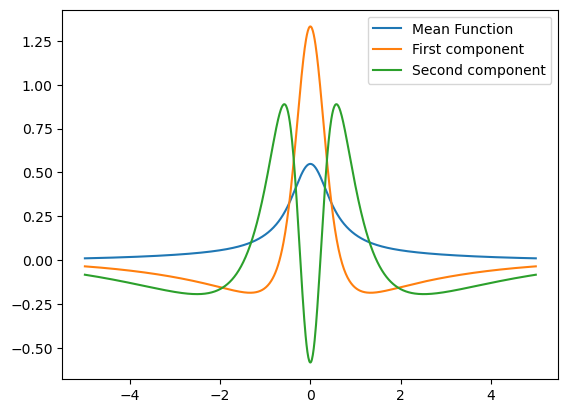

In [13]:
# Plot the mean function and the first two eigenfunctions
fig, ax = plt.subplots()
ax.plot(grid_densities_univ, mean_function, label="Mean Function")
ax.plot(grid_densities_univ, -eigenfunctions[:, 0], label="First component")
ax.plot(grid_densities_univ, eigenfunctions[:, 1], label="Second component")
plt.legend()
plt.show()

## More reproducing of Petersen & Müller (2016)

In [14]:
# Compute first two modes of variation
first_two_modes = mode_of_variation(
    mean_function,
    eigenvalues[:2],
    eigenfunctions[:, :2],
    1
)

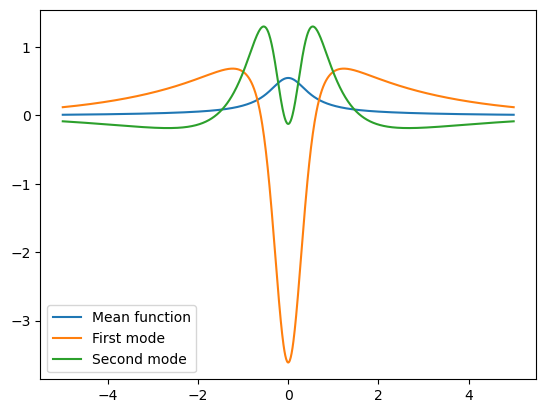

In [15]:
fig, ax = plt.subplots()
ax.plot(grid_densities_univ, mean_function, label="Mean function")
ax.plot(grid_densities_univ, first_two_modes[:, 0], label="First mode")
ax.plot(grid_densities_univ, first_two_modes[:, 1], label="Second mode")
plt.legend()
plt.show()

## Fréchet mean estimation

In [69]:
def wasserstein_frechet_mean(qds_discretized, grid, qdsup=None):
    """Compute Wasserstein-Fréchet mean from sample."""
    mean_qdf = np.mean(qds_discretized, axis=0)
    return density_from_qd(mean_qdf, grid, qdsup)

In [111]:
def density_from_qd(qd, dsup, qdsup=None):
    """Compute density from a quantile density function.

    'Inspired' from qd2dens in fdadensity package in R.

    """
    if qdsup is None:
        qdsup = np.linspace(0, 1, len(qd))
    quantile_oplus = dsup[0] + riemann_sum_arrays(
        support_grid=qdsup, array=qd, axis=0, cumsum=True
    )

    dens_temp = 1 / qd
    ind = np.unique(quantile_oplus, return_index=True)[1]
    quantile_oplus = np.atleast_1d(quantile_oplus)[ind]
    dens_temp = dens_temp[~ind]
    dens = np.interp(dsup, quantile_oplus, dens_temp)
    dens /= riemann_sum_arrays(dsup, dens, axis=0, cumsum=False)

    return dens, quantile_oplus

In [117]:
f_oplus, quantile_oplus = wasserstein_frechet_mean(
    quantile_densities_discretized,
    grid_densities_univ,
    grid_quantiles_univ
)
F_oplus = cdf_from_density(
    grid_densities_univ,
    f_oplus,
    axis=0,
)
F_oplus[-1]

1.0

In [118]:
quantile_oplus.min()

-4.972027496593154

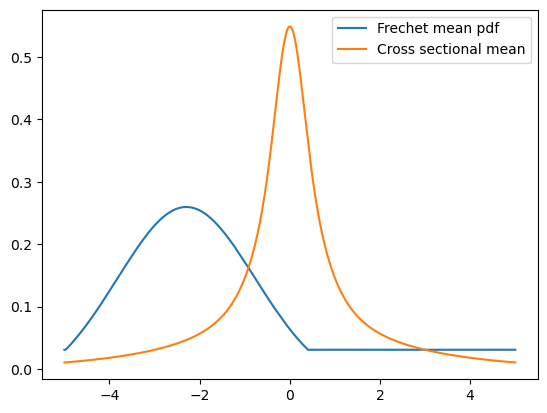

In [119]:
fig, ax = plt.subplots()
ax.plot(grid_densities_univ, f_oplus, label="Frechet mean pdf")
ax.plot(grid_densities_univ, mean_function, label="Cross sectional mean")
# ax.plot(grid_densities_univ, densities_discretized[0], label="First pdfs")
# ax.plot(grid_densities_univ, densities_discretized[1], label="Second pdfs")
# ax.plot(grid_densities_univ, densities_discretized[40], label="Third pdfs")

# ax.plot(grid_densities_univ, F_oplus, label="Frechet mean cdf")
plt.legend()
plt.show()

In [49]:
# My naive wf mean:
mean_qdf = mean_qdf = np.mean(qds_discretized, axis=0)


In [116]:
mean_qdf

array([27.9445309 , 26.28310585, 24.84117896, 23.56908602, 22.47296549,
       21.49598014, 20.64438777, 19.84585799, 19.15210174, 18.49355977,
       17.91460093, 17.37061533, 16.87684899, 16.39845526, 15.96967953,
       15.56056667, 15.19150874, 14.83412163, 14.50004137, 14.18017987,
       13.89631276, 13.60271436, 13.34119152, 13.08954928, 12.85093343,
       12.61857165, 12.40346024, 12.19226093, 11.99586326, 11.80025572,
       11.62527963, 11.43750605, 11.27378518, 11.11492038, 10.95375125,
       10.80403063, 10.65904525, 10.52386069, 10.38615118, 10.2575412 ,
       10.12965579, 10.00395177,  9.88997645,  9.76985511,  9.66552506,
        9.55512679,  9.45128688,  9.34806602,  9.24865259,  9.15441592,
        9.06335793,  8.97330035,  8.88031124,  8.79431681,  8.71688908,
        8.6331683 ,  8.55538925,  8.47989429,  8.39913125,  8.32533597,
        8.25199245,  8.18404848,  8.11414152,  8.04766627,  7.98299369,
        7.91801452,  7.85921509,  7.79429026,  7.73427466,  7.67

In [50]:
def fve(k):
    """Compute explained variance."""
    return np.sum(eigenvalues[:k]) / np.sum(eigenvalues)


fve(1), fve(2)

(0.8613366313840514, 0.9783567653735017)